In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import trange

from utils import get_label, get_multi_label, plot_roc, evaluate, Imputer, Vectorizer, Splitter

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [33]:
data = pd.read_csv("data/train.tsv", sep="\t")
x_train, x_test, y_train_multi, y_test_multi = train_test_split(data.drop("label", axis=1), get_multi_label(data), random_state=RANDOM_SEED)
y_train = torch.tensor([1 if y == 0 else 0 for y in y_train_multi]).float()
y_test = torch.tensor(np.array([1 if y == 0 else 0 for y in y_test_multi])).float()

x_train.head()

,statement,subject,speaker,speaker_job,state,party,context
10148,Nearly 65 percent -- almost two-thirds -- of a...,immigration,jeb-bush,NaN,Florida,republican,in his book 'Immigration Wars'
6904,"Says that except for foreign policy, Ron Pauls...",voting-record,paul-broun,Congressman,Georgia,republican,a fundraiser letter
1721,Ronald Reagan banned ownership of fully automa...,"guns,history",alfonso-lopez,State delegate,Virginia,democrat,a floor speech.
5466,Americans now support strikes (against ISIS) b...,"polls,terrorism",katrina-vanden-heuvel,NaN,NaN,none,"a panel on ABC's ""This Week"""
6794,"Amendment 2 will put almost 2,000 pot shops in...","florida-amendments,marijuana",vote-no-2,NaN,Florida,none,a video


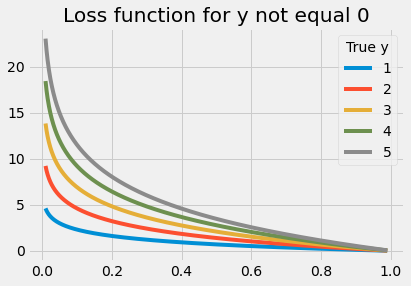

In [34]:
y_pred = np.linspace(0.01, 0.99, 1000)
loss_1 = -np.log(y_pred)
loss_2 = 2*loss_1
loss_3 = 3*loss_1
loss_4 = 4*loss_1
loss_5 = 5*loss_1
plt.plot(y_pred, loss_1, label="1")
plt.plot(y_pred, loss_2, label="2")
plt.plot(y_pred, loss_3, label="3")
plt.plot(y_pred, loss_4, label="4")
plt.plot(y_pred, loss_5, label="5")
plt.title("Loss function for y not equal 0")
plt.legend(title="True y");

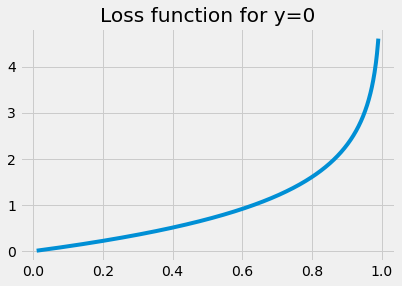

In [35]:
loss_0 = -np.log(1 - y_pred)
plt.plot(y_pred, loss_0)
plt.title("Loss function for y=0");

In [36]:
impute_vectorize = Pipeline([
    ("imputer", Imputer), ("vectorizer", Vectorizer)
])

split_vectorize = Pipeline([
    ("splitter", Splitter), ("vectorizer", Vectorizer)
])

column_transformer = ColumnTransformer([
       ("statement_vectorizer", Vectorizer ,"statement"),
        ("subject_vectorizer", split_vectorize, "subject"),
        ("job", impute_vectorize, "speaker_job"),
        ("state", impute_vectorize, "state"),
        ("party", impute_vectorize, "party"),
        ("context", impute_vectorize, "context")
    ])


pipeline = Pipeline([
    ("get_features", column_transformer),
    ("predict", LogisticRegression(max_iter=1000, C=0.64))
])

In [37]:
x_train_transformed = column_transformer.fit_transform(x_train).toarray()

In [38]:
x = torch.from_numpy(x_train_transformed).float()

In [39]:
w = torch.randn(size=(4206,)).requires_grad_()
weight = torch.tensor([1 if y == 0 else y for y in y_train]).float()
def get_weight(label, weights=(1, 1, 1, 1)):
    weight_dict = {
        0: 1,
        1: 1,
        2: 1
        3: 1
        4: 1,
        5: 1
    }
    return weight_dict[label]
weight = torch.tensor([get_weight(label) for label in y_multi])

In [42]:
w = torch.randn(size=(4206,)).requires_grad_()
criterion = nn.BCEWithLogitsLoss(weight=weight)
optimizer = torch.optim.Adam((w,), lr=0.1, weight_decay=0.0001)

losses = []

n_epochs = 100
for i in trange(n_epochs):
    optimizer.zero_grad()
    logits = x @ w
    loss = criterion(logits, y_train)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

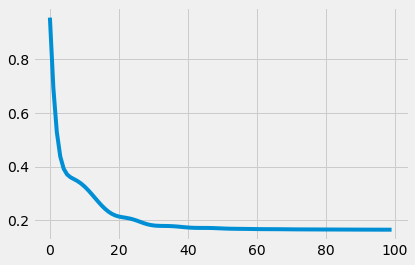

In [44]:
plt.plot(losses)

In [48]:
probas = torch.sigmoid(x @ w).detach().numpy()

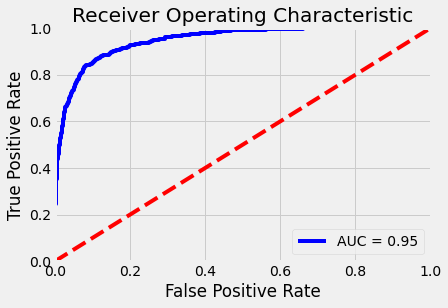

0.9476698206468012

In [49]:
plot_roc(y_train, probas)

In [50]:
x_test_transformed = column_transformer.transform(x_test).toarray()
x_test_t = torch.tensor(x_test_transformed).float()

In [51]:
probas = torch.sigmoid(x_test_t @ w).detach().numpy()

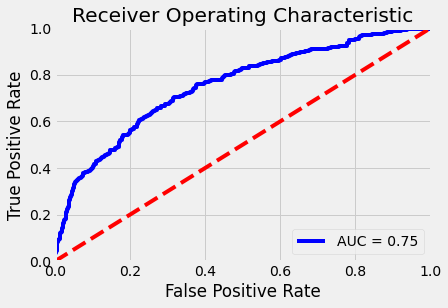

0.751301408017826

In [52]:
plot_roc(y_test, probas)

#### Evaluation

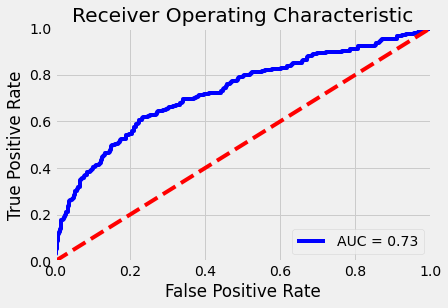

0.72677154766707

In [53]:
def get_weight(label):
    if label == 0:  # pants-fire
        return 1
    elif label == 1:  # false
        return 0.5
    if label == 2:  # barely-true
        return 1
    elif label == 3:  # half-true
        return 1
    elif label == 4:  # mostly-true
        return 5
    elif label == 5:  # true
        return 10
    else:
        return 1
weight = torch.tensor([get_weight(label) for label in y_multi])

w = torch.randn(size=(4206,)).requires_grad_()
criterion = nn.BCEWithLogitsLoss(weight=weight)
optimizer = torch.optim.Adam((w,), lr=0.1, weight_decay=0.0005)

losses = []

n_epochs = 100
for i in trange(n_epochs):
    optimizer.zero_grad()
    logits = x @ w
    loss = criterion(logits, y)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    
probas = torch.sigmoid(x_test_t @ w).detach().numpy()
plot_roc(y_test, probas)

In [55]:
type(x)

torch.Tensor

In [56]:
a = np.zeros(10)

In [57]:
b = torch.tensor(a)

In [130]:
class Model:
    def __init__(self, loss_weights=None):
        self.loss_weights = loss_weights
        self.w = torch.randn(size=(4206,)).requires_grad_()
        self.losses = []
        
    @staticmethod
    def tensor(x):
        if type(x) != torch.Tensor:
            x = torch.tensor(x)
        return x.float()
        
    def fit(self, x, y_multi, *, n_epochs=300, weight_decay=0.0005, lr=0.1):
        self.losses = []
        x = self.tensor(x)
        y = torch.tensor(np.array([1 if y == 0 else 0 for y in y_multi])).float()
        weight_dict = {
            0: 1,
            1: 1,
            2: 1,
            3: 1,
            4: 1,
            5: 1
        }
        weight = torch.tensor([weight_dict[label] for label in y_multi])
        criterion = nn.BCEWithLogitsLoss(weight=weight)
        optimizer = torch.optim.Adam((self.w,), lr=lr, weight_decay=weight_decay)
        n_epochs = 100
        for i in trange(n_epochs):
            optimizer.zero_grad()
            logits = x @ self.w
            loss = criterion(logits, y)
            loss.backward()
            self.losses.append(loss.item())
            optimizer.step()
        plt.plot(losses)
        plt.title("Loss")
        plt.xlabel("iteration")
        plt.show()
            
            
    def predict(self, x):
        x = self.tensor(x)
        logits = x @ self.w
        probas = torch.sigmoid(logits)
        y_pred = np.array([1 if p > 0.5 else 0 for p in probas])
        return y_pred
    
    def predict_proba(self, x):
        x = self.tensor(x)
        logits = x @ self.w
        probas = torch.sigmoid(logits).detach()
        return torch.stack([1 - probas, probas]).transpose(0, 1).numpy()

In [131]:
model = Model()

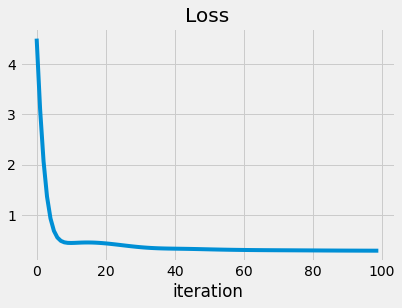

In [132]:
model.fit(x_train_transformed, y_train_multi)

Accuracy: 91.43
F-1 score: 0.0351


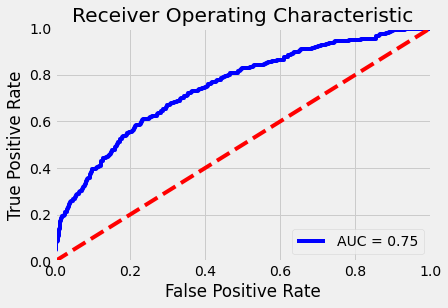

In [133]:
evaluate(model, x_test_transformed, y_test)

In [73]:
torch.stack([1 - probas, probas]).transpose(0, 1)

tensor([0.0104, 0.0273, 0.0394,  ..., 0.0013, 0.0131, 0.0033],
       grad_fn=<SelectBackward>)